<img src="http://hilpisch.com/tpq_logo.png" alt="The Python Quants" width="35%" align="right" border="0"><br>

# Python for Asset Management

### Combining ML with BL92

&copy; Dr. Yves J. Hilpisch | The Python Quants GmbH

http://tpq.io | [training@tpq.io](mailto:trainin@tpq.io) | [@dyjh](http://twitter.com/dyjh)

## Expected Return Predictions

Topics of interest include:

* deep learning-based predictions
* BL92 adjustments for returns
* BL92 adjustmets for covariance matrix
* mean-variance optimal portfolios

# Imports & Configurations

In [1]:
import numpy as np
import pandas as pd
import datetime as dt
from pylab import mpl, plt

In [3]:
np.random.seed(1000)
plt.style.use('seaborn')
#pd.set_option('precision', 4)
pd.set_option('display.float_format', '{:.4f}'.format)
np.set_printoptions(suppress=True, precision=4)
%config InlineBackend.figure_format = 'svg'

## The Data

In [4]:
raw = pd.read_csv('http://hilpisch.com/aiif_eikon_eod_data.csv',
                      index_col=0, parse_dates=True)

In [5]:
noa = 3

In [6]:
symbols = raw.columns[:noa]
symbols

Index(['AAPL.O', 'MSFT.O', 'INTC.O'], dtype='object')

In [7]:
data = pd.DataFrame(raw[symbols])

In [8]:
rets = np.log(data / data.shift(1))

In [9]:
rets.dropna(inplace=True)

In [10]:
rets.head()

,AAPL.O,MSFT.O,INTC.O
Date,,,
2010-01-05,0.0017,0.0003,-0.0005
2010-01-06,-0.0160,-0.0062,-0.0034
2010-01-07,-0.0019,-0.0104,-0.0097
2010-01-08,0.0066,0.0068,0.0111
2010-01-11,-0.0089,-0.0128,0.0057


In [11]:
lags = 3

In [12]:
def create_lags(rets):
    global cols
    cols = []
    for sym in rets.columns:
        for lag in range(1, lags + 1):
            col = f'{sym}_lag_{lag}'
            rets[col] = rets[sym].shift(lag)
            cols.append(col)

In [13]:
create_lags(rets)

In [14]:
cols

['AAPL.O_lag_1',
 'AAPL.O_lag_2',
 'AAPL.O_lag_3',
 'MSFT.O_lag_1',
 'MSFT.O_lag_2',
 'MSFT.O_lag_3',
 'INTC.O_lag_1',
 'INTC.O_lag_2',
 'INTC.O_lag_3']

In [15]:
rets.dropna(inplace=True)

## Predicting Returns

In [16]:
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, accuracy_score

In [17]:
model = MLPRegressor(hidden_layer_sizes=2 * [32,],
                    random_state=100, shuffle=False)

In [18]:
weeks = pd.date_range(rets.index[0], rets.index[-1], freq='w')

In [19]:
weeks

DatetimeIndex(['2010-01-10', '2010-01-17', '2010-01-24', '2010-01-31',
               '2010-02-07', '2010-02-14', '2010-02-21', '2010-02-28',
               '2010-03-07', '2010-03-14',
               ...
               '2019-10-27', '2019-11-03', '2019-11-10', '2019-11-17',
               '2019-11-24', '2019-12-01', '2019-12-08', '2019-12-15',
               '2019-12-22', '2019-12-29'],
              dtype='datetime64[ns]', length=521, freq='W-SUN')

In [20]:
start = 51

In [21]:
%%time
rets_ = pd.DataFrame()
for w in weeks[start:-1]:
    train = rets.loc[:w].copy()
    mu, std = train.mean(), train.std()
    train_ = (train - mu) / std
    model.fit(train_[cols], train[symbols])
    test = rets.loc[w:w + weeks.freq].copy()
    test_ = (test - mu) / std
    rets_ = rets_.append(pd.DataFrame(model.predict(test_[cols]),
                                  columns=symbols, index=test.index))  

<timed exec>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a 

CPU times: user 30.2 s, sys: 439 ms, total: 30.6 s
Wall time: 30.8 s


<timed exec>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


In [22]:
rets_.head() - rets.loc[rets_.head().index, symbols]

,AAPL.O,MSFT.O,INTC.O
Date,,,
2011-01-03,0.0143,0.0024,-0.1347
2011-01-04,0.0825,0.0222,-0.0612
2011-01-05,-0.0245,-0.1877,-0.0089
2011-01-06,0.0285,-0.0763,-0.0615
2011-01-07,0.1875,-0.0566,0.0716


## BL92 Optimal Portfolios

In [23]:
import bl92_portfolio as bl92

In [24]:
symbols

Index(['AAPL.O', 'MSFT.O', 'INTC.O'], dtype='object')

In [25]:
# rets__ = rets_.rolling(20).mean().dropna()

In [26]:
r = rets_

In [27]:
r.head()

,AAPL.O,MSFT.O,INTC.O
Date,,,
2011-01-03,0.0358,0.0049,-0.1433
2011-01-04,0.0877,0.0260,-0.0469
2011-01-05,-0.0164,-0.1908,-0.0189
2011-01-06,0.0277,-0.0474,-0.0697
2011-01-07,0.1946,-0.0643,0.0663


In [28]:
stop = None

In [29]:
w = r.iloc[:stop].copy()

In [30]:
bl = bl92.BL92Portfolio(symbols)
bl.tau = 1

In [52]:
bl.omega

array([[0.1, 0. , 0. ],
       [0. , 0.1, 0. ],
       [0. , 0. , 0.1]])

In [31]:
# bnds = noa * [(0, 1)]
bnds = noa * [(-1, 1)]

In [32]:
%%time
for pred in r.iloc[:stop].iterrows():
    bl.end = pred[0]
    bl.views = list()
    for sym in pred[1].index:
        q = pred[1][sym]
        bl.views.append([{sym: 1}, q, 0.1])
    bl.generate_bl_objects()
    bl.generate_bl_statistics()
    opt = bl.maximum_sharpe_portfolio(bnds=bnds)
    w.loc[pred[0]] = opt['weights'].values.flatten()

CPU times: user 6.59 s, sys: 943 ms, total: 7.53 s
Wall time: 7.28 s


In [33]:
w.iloc[-3:]

,AAPL.O,MSFT.O,INTC.O
Date,,,
2019-12-23,0.6374,0.6791,-0.3165
2019-12-24,0.6834,0.5413,-0.2247
2019-12-27,0.5953,0.5899,-0.1853


In [34]:
bl.mu_ - bl.mu

AAPL.O   -0.0913
MSFT.O   -0.0656
INTC.O   -0.0589
dtype: float64

In [35]:
bl.cov_ - bl.cov

,AAPL.O,MSFT.O,INTC.O
AAPL.O,0.0371,0.0092,0.0087
MSFT.O,0.0092,0.0300,0.0121
INTC.O,0.0087,0.0121,0.0339


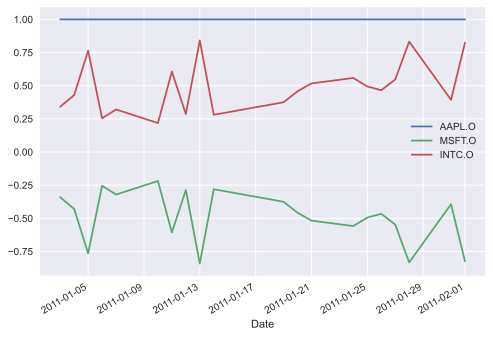

In [36]:
w.iloc[:20].plot();

In [37]:
rets_.iloc[0]

AAPL.O    0.0358
MSFT.O    0.0049
INTC.O   -0.1433
Name: 2011-01-03 00:00:00, dtype: float64

In [38]:
w.iloc[0]

AAPL.O    1.0000
MSFT.O   -0.3410
INTC.O    0.3410
Name: 2011-01-03 00:00:00, dtype: float64

In [39]:
strat = w * rets.loc[w.index[0]:].iloc[:stop][symbols]

In [46]:
strat

,AAPL.O,MSFT.O,INTC.O
Date,,,
2011-01-03,0.0215,-0.0009,-0.0029
2011-01-04,0.0052,-0.0016,0.0061
2011-01-05,0.0081,0.0024,-0.0076
2011-01-06,-0.0008,-0.0073,-0.0021
2011-01-07,0.0071,0.0025,-0.0017
...,...,...,...
2019-12-19,0.0007,0.0046,-0.0026
2019-12-20,-0.0016,0.0065,-0.0066
2019-12-23,0.0103,0.0000,-0.0015


In [40]:
strat.dropna(inplace=True)

In [41]:
len(strat)

2180

In [42]:
strat.head()

,AAPL.O,MSFT.O,INTC.O
Date,,,
2011-01-03,0.0215,-0.0009,-0.0029
2011-01-04,0.0052,-0.0016,0.0061
2011-01-05,0.0081,0.0024,-0.0076
2011-01-06,-0.0008,-0.0073,-0.0021
2011-01-07,0.0071,0.0025,-0.0017


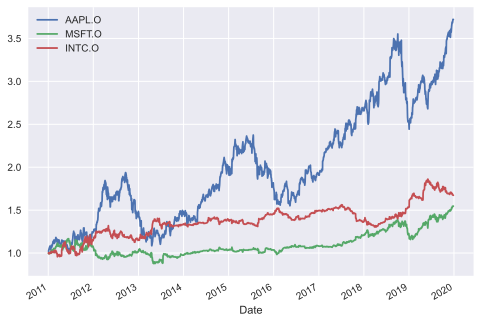

In [43]:
strat.cumsum().apply(np.exp).plot(label='Portfolio')
plt.legend();  # out-of-sample performance

In [44]:
strat.tail()

,AAPL.O,MSFT.O,INTC.O
Date,,,
2019-12-19,0.0007,0.0046,-0.0026
2019-12-20,-0.0016,0.0065,-0.0066
2019-12-23,0.0103,0.0000,-0.0015
2019-12-24,0.0006,-0.0001,-0.0007
2019-12-27,-0.0002,0.0011,-0.0008


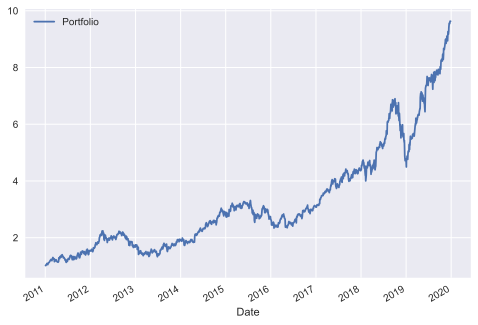

In [45]:
strat.cumsum().sum(axis=1).apply(np.exp).plot(label='Portfolio')
plt.legend();  # out-of-sample performance

<img src="http://hilpisch.com/tpq_logo.png" alt="The Python Quants" width="35%" align="right" border="0"><br>

<a href="http://tpq.io" target="_blank">http://tpq.io</a> | <a href="http://twitter.com/dyjh" target="_blank">@dyjh</a> | <a href="mailto:training@tpq.io">training@tpq.io</a>